<a href="https://colab.research.google.com/github/EvanM19/Projet-scoring/blob/main/descriptive%20statistics/Feature_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature_selection and descriptive analysis



### Data and library importation

In [1]:
import pandas as pd
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)

In [2]:
samples = pd.read_excel('../data/samples.xlsx', sheet_name=None)

colonnes_a_supprimer = [ 'id_client', 'CODTYPPRS', 'CRTOD_CMT_PRO_IND_0209','INDPARDCD','CRTOP_AG_IND_0038', 'CRTOP_IND_0038', 'CRTOU_CCT_PRO_IND_0209', 'DATCREENT', 'DATRLNORG', 'RATIO1', 'RATIO3', 'TOP_PRO_ACTIF', 'IND_ACTIF', 'IND_PER_PM', 'CODCMNIEE', 'CODPAY_NAISSANCE', 'CODPAY_NATIONALITE', 'CODPAY_RESIDENCE', 'CODSEXPRS', 'secteur_activite', 'secteur_activite_bis' ]

samples = samples
train = samples[list(samples.keys())[0]]
train = train.drop(columns=colonnes_a_supprimer)
test = samples[list(samples.keys())[1]]
test = test.drop(columns=colonnes_a_supprimer)
oot = samples[list(samples.keys())[2]]
oot = oot.drop(columns=colonnes_a_supprimer)
sample = pd.concat([train, test, oot], ignore_index=True)

In [3]:

sample['datdelhis'] = sample['datdelhis'] % 100
sample['datdelhis'] = sample['datdelhis'].astype(str)

quali=['DDefaut_NDB','datdelhis','AGEPRS','CODITDBDF_PRO','CODETAJUR','CODNAF2']


### Plots

In [4]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


# Créer le dossier pour sauvegarder les graphiques
output_dir = "plots"
os.makedirs(output_dir, exist_ok=True)


def plot_distribution(data, feature, is_quali, upper_percentile=0.99):
    """Fonction pour générer des graphiques de distribution pour les features."""
    feature_dir = os.path.join(output_dir, feature)
    os.makedirs(feature_dir, exist_ok=True)

    plt.figure(figsize=(10, 6))
    
    if is_quali:
        plot_histogram(data, feature, feature_dir)
        plot_histogram_by_target(data, feature, feature_dir)
        plot_observations_per_modality_over_time(data, feature, feature_dir)
    else:
        plot_histogram_without_extreme_values(data, feature, feature_dir, upper_percentile)
        plot_density_by_target(data, feature, feature_dir, upper_percentile)
        plot_boxplots_by_date(data, feature, feature_dir, upper_percentile)
    
    plt.close()


def plot_histogram(data, feature, feature_dir):
    """Affiche un histogramme simple pour la feature donnée."""
    plt.figure(figsize=(10, 6))
    sns.histplot(data[feature], bins=30, kde=False, color='blue', alpha=0.7)
    plt.title(f"Histogramme de {feature}")
    plt.xlabel(feature)
    plt.ylabel("Fréquence")
    
    file_path = os.path.join(feature_dir, f"histogramme.pdf")
    plt.savefig(file_path)


def plot_histogram_by_target(data, feature, feature_dir):
    """Affiche un histogramme où chaque modalité est représentée par deux barres : une pour target=0 et une pour target=1."""
    
    # Calcul des fréquences pour chaque modalité de la feature en fonction du target
    counts_0 = data[data['DDefaut_NDB'] == 0][feature].value_counts(normalize=True)
    counts_1 = data[data['DDefaut_NDB'] == 1][feature].value_counts(normalize=True)
    
    # Trouver toutes les modalités (uniquement les modalités présentes dans l'une ou l'autre des catégories de target)
    categories = list(set(counts_0.index).union(set(counts_1.index)))
    counts_0 = counts_0.reindex(categories, fill_value=0)
    counts_1 = counts_1.reindex(categories, fill_value=0)
    
    # Position des barres
    x = range(len(categories))

    # Affichage de l'histogramme
    plt.figure(figsize=(10, 6))
    plt.bar(x, counts_0, width=0.4, label='Cible = 0', align='center', alpha=0.7, color='blue')
    plt.bar([xi + 0.4 for xi in x], counts_1, width=0.4, label='Cible = 1', align='center', alpha=0.7, color='red')

    # Paramètres de l'histogramme
    plt.xticks([xi + 0.2 for xi in x], categories, rotation=45)
    plt.title(f"Distribution de {feature} en fonction du défaut")
    plt.xlabel(feature)
    plt.ylabel("Proportion")
    plt.legend()

    # Sauvegarde du graphique dans le dossier de la feature
    file_path = os.path.join(feature_dir, f"histogramme_par_defaut.pdf")
    plt.tight_layout() 
    plt.savefig(file_path)
    plt.close()


def plot_observations_per_modality_over_time(data, feature, feature_dir):
    """Affiche un graphique montrant le nombre d'observations pour chaque modalité d'une variable qualitative au cours du temps."""
    
    # Calculer le nombre d'observations pour chaque modalité de la feature, par période de temps
    observation_counts = data.groupby(['datdelhis', feature]).size().unstack(fill_value=0)

    # Tracer le graphique
    plt.figure(figsize=(10, 6))
    observation_counts.plot(kind='line', marker='o', figsize=(10, 6))
    plt.title(f"Nombre d'observations par modalité de {feature} au cours du temps")
    plt.xlabel("Période")
    plt.ylabel("Nombre d'observations")
    plt.grid(True)
    plt.legend(title=feature, bbox_to_anchor=(1.05, 1), loc='upper left')

    # Sauvegarde du graphique
    file_path = os.path.join(feature_dir, f"observations_par_modalite_au_cours_du_temps.pdf")
    plt.tight_layout()
    plt.savefig(file_path)


def plot_histogram_without_extreme_values(data, feature, feature_dir, upper_percentile):
    """Affiche un histogramme simple pour la feature donnée, sans inclure les valeurs égales à 0, et filtre les valeurs extrêmes."""
    
    # Filtrage des valeurs extrêmes en utilisant les percentiles
    upper_bound = data[feature].quantile(upper_percentile)
    
    # Appliquer le filtrage des valeurs extrêmes
    data = data[(data[feature] <= upper_bound)]
    
    # Affichage de l'histogramme pour la feature filtrée
    plt.figure(figsize=(10, 6))
    sns.histplot(data[feature], bins=30, kde=False, color='blue', alpha=0.7)
    plt.title(f"Histogramme de {feature}")
    plt.xlabel(feature)
    plt.ylabel("Fréquence")
    
    # Sauvegarde du graphique dans le dossier de la feature
    file_path = os.path.join(feature_dir, f"histogramme.pdf")
    plt.tight_layout() 
    plt.savefig(file_path)


def plot_density_by_target(data, feature, feature_dir, upper_percentile):
    """Affiche une densité en fonction de la cible pour une feature donnée, avec filtrage des valeurs extrêmes et exclusion des valeurs égales à 0."""
    
    # Filtrage des valeurs extrêmes en utilisant les percentiles
    upper_bound = data[feature].quantile(upper_percentile)
    
    # Appliquer le filtrage des valeurs extrêmes
    data = data[(data[feature] <= upper_bound)]
    
    # Affichage des courbes de densité pour chaque valeur de la target
    plt.figure(figsize=(10, 6))
    
    sns.kdeplot(data=data[data['DDefaut_NDB'] == 0][feature], label=f'Cible = 0', fill=True, alpha=0.5)
    sns.kdeplot(data=data[data['DDefaut_NDB'] == 1][feature], label=f'Cible = 1', fill=True, alpha=0.5)
    
    # Titre et labels
    plt.title(f"Densité de {feature} par défaut")
    plt.xlabel(feature)
    plt.ylabel("Densité")
    plt.legend(title='DDefaut_NDB')
    
    # Sauvegarde du graphique dans le dossier de la feature
    file_path = os.path.join(feature_dir, f"density_by_target.pdf")
    plt.tight_layout() 
    plt.savefig(file_path)


def plot_boxplots_by_date(data, feature, feature_dir, upper_percentile):
    """Affiche des boxplots pour la feature donnée en fonction des dates, avec filtrage des valeurs extrêmes."""
    
    # Filtrage des valeurs extrêmes en utilisant les percentiles
    upper_bound = data[feature].quantile(upper_percentile)
    
    # Appliquer le filtrage des valeurs extrêmes
    data = data[(data[feature] <= upper_bound)]
   
    # Création du boxplot pour chaque date
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='datdelhis', y=feature, data=data, palette='pastel', showfliers=False)
    
    # Titre et labels
    plt.title(f"Boxplot de {feature} par date")
    plt.xlabel('Date')
    plt.ylabel(feature)
    
    # Sauvegarde du graphique dans le dossier de la feature
    file_path = os.path.join(feature_dir, f"boxplot_by_date.pdf")
    plt.tight_layout()
    plt.savefig(file_path)

<Figure size 1000x600 with 0 Axes>

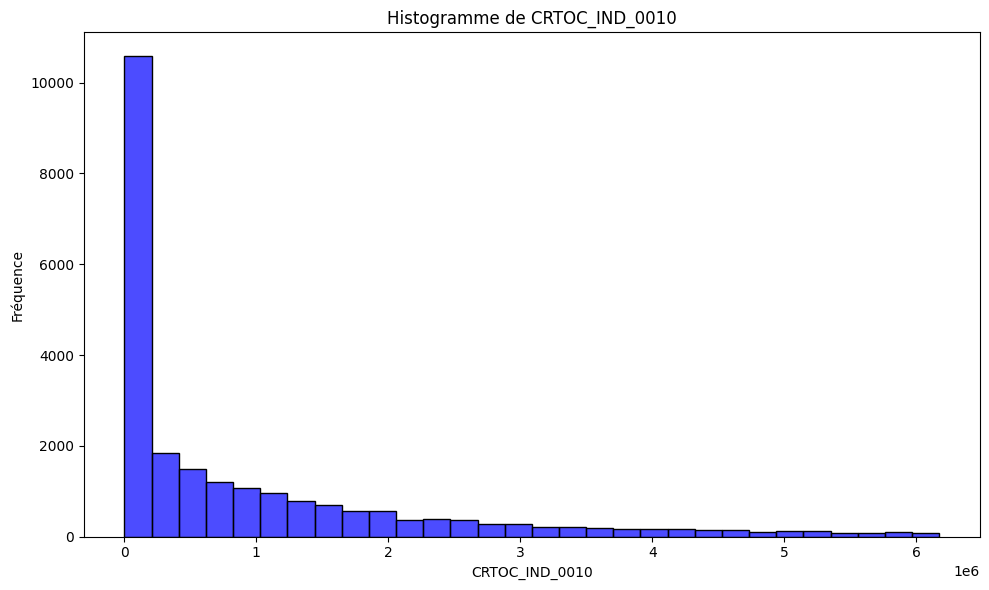

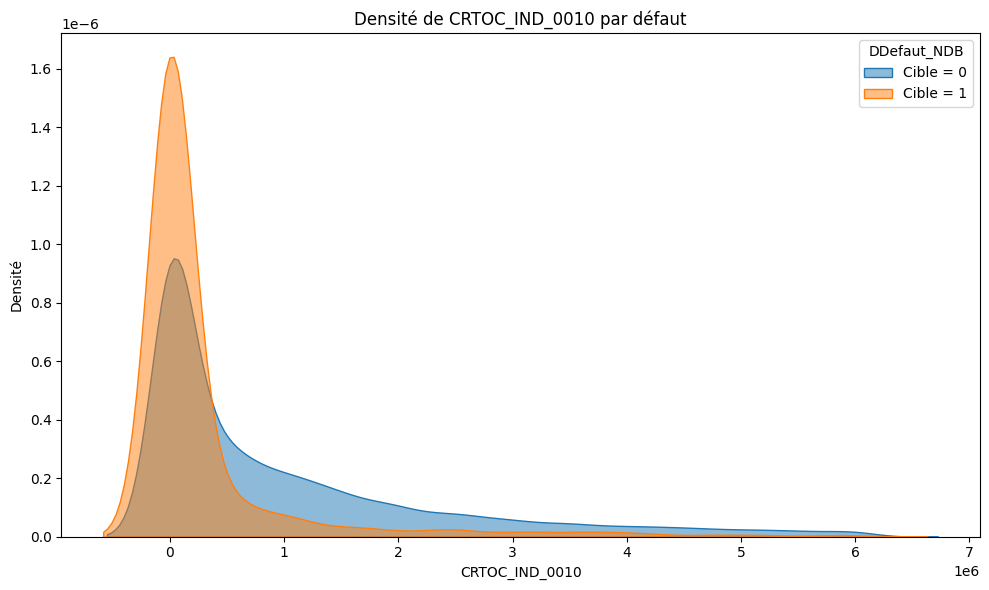

In [6]:
plot_distribution(sample, 'CRTOC_IND_0010', False, upper_percentile=0.90)